# Lego Part Lifespans

Requirements to run as-is:
* Google Colab and Google Drive
* Drive folder `/lego`
* Folder `/lego` contains Rebrickable [downloads](https://rebrickable.com/downloads/)
* Folder `/lego` contains a Rebrickable [API](https://rebrickable.com/api/v3/docs/) Key in the file `rbl`



# Get Data

## Google Drive

In [1]:
UPLOAD_FOLDER = 'My Drive/lego/'
CACHE_FOLDER = 'cache/'

GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CACHE_DIR = RAW_ROOT + CACHE_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_df(fname):
  return pd.read_csv(RAW_ROOT + fname)

# Rebrickable downloads
parts_df = get_df('parts.csv').set_index('part_num')
sets_df = get_df('sets.csv').set_index('set_num')
inventories_df = get_df('inventories.csv').set_index('id')
inventory_parts_df = get_df('inventory_parts.csv').set_index('inventory_id')

## Rebrickable API & Drive Cache

In [3]:
import requests

RBL_HOST = 'https://rebrickable.com'
RBL_ROOT = '/api/v3/lego/'
RBL_PRE = RBL_HOST + RBL_ROOT

key_file = open(RAW_ROOT + 'rbl', 'r')
rbl_api_key = key_file.readlines()[0].strip()
auth_value = 'key ' + rbl_api_key
RBL_HDR = {'Authorization': auth_value }

def get_rbl_uri(uri):
  return requests.get(uri, headers=RBL_HDR).json()

def get_part_details(part_num):
  return requests.get(RBL_PRE + f'parts/{part_num}', headers=RBL_HDR).json()

def get_part_list_details(part_nums):
  part_nums_param_val = ','.join([str(p) for p in part_nums])
  other_params = '&inc_part_details=1&page_size=1000'
  uri = RBL_PRE + f'parts/?part_nums={part_nums_param_val}' + other_params
  return requests.get(uri, headers=RBL_HDR).json()

In [4]:
import glob
import json
import time

def write_part_results(results, page_num):
  Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
  results_file_name = CACHE_DIR + f'results_page_{page_num:03d}.json'
  with open(results_file_name, 'w') as outfile:
    json.dump(results, outfile)

def cache_all_parts(max_pages=100):
  page_index = 0
  page_response = get_part_list_details([])
  while page_response['next'] is not None and page_index < max_pages:
    print(f'caching results page {page_index}')
    write_part_results(page_response['results'], page_index)
    page_index = page_index + 1
    # be nice to Rebrickable API
    time.sleep(10)
    page_response = get_rbl_uri(page_response['next'])

cache_exists = len(glob.glob(CACHE_DIR + '*.json')) > 0
if not cache_exists:
  cache_all_parts()
else:
  print('cache exists')

cache exists


In [5]:
def build_cache_index():
  dir_list = sorted(glob.glob(CACHE_DIR + '*.json'))
  json_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      json_cache = json_cache + data
  return {p['part_num'] : p for p in json_cache}

# Test Find Part in Set

Orange flipper in 2013 city coastguard set

In [6]:
test_set_num = '60012-1'
test_inventory_id = inventories_df[inventories_df['set_num'] == test_set_num].index[0]
test_inventory_id

14207

In [7]:
test_part_list = list(inventory_parts_df[inventory_parts_df.index == test_inventory_id]['part_num'])
print(test_part_list)

['10190', '10190', '13611', '14181', '14520', '15207', '2412b', '2431', '2431', '2446', '2508', '2877', '30086', '30090', '30090', '30091', '3010', '30157', '3020', '3021', '3021', '3022', '3023', '3024', '3024', '3039', '3068b', '3069b', '3626c', '3660', '3710', '3710', '3821', '3822', '3829c01', '3962b', '4081b', '42610', '4349', '44301a', '44728', '45677', '47457', '48336', '4865a', '4871', '52036', '52501', '54200', '54200', '54200', '54200', '54200', '54200', '56890', '57783', '6014b', '60470a', '60475b', '60478', '6141', '6141', '6141', '6141', '6141', '6141', '6157', '6187', '63082', '87580', '88072', '88930', '92409', '98282', '99780']


In [8]:
parts_df[parts_df.index == test_part_list[0]]

,name,part_cat_id,part_material
part_num,,,
10190,Minifig Footwear Flipper [Thick],27,Plastic


# Lifespan Analysis

In [9]:
jcpn = build_cache_index()

max_year = 2020
ordered_part_values = list(jcpn.values())

# year released, limiting values to desrired range
yrel = [p['year_from'] for p in ordered_part_values if 0 < p['year_from'] <= max_year]
# year retired is considered year_to + 1 so lifespan >= 1
yret = [p['year_to'] + 1 for p in ordered_part_values if 0 < p['year_from'] <= max_year]

## Distribution

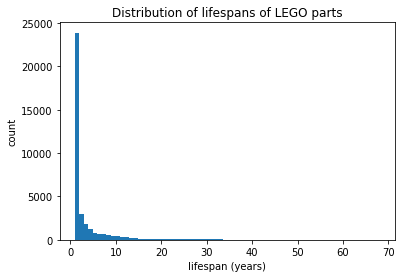

In [10]:
lf = [ret - rel for rel, ret in zip(yrel, yret)]
plt.hist(lf, bins=max(lf))
plt.ylabel('count')
plt.xlabel('lifespan (years)')
plt.title('Distribution of lifespans of LEGO parts')
plt.show()

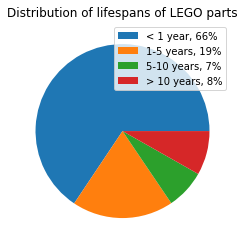

In [11]:
lf_counts = np.unique(lf, return_counts=True)
lf_1_count = sum([c for l, c in zip(lf_counts[0], lf_counts[1]) if l <= 1])
lf_5_count = sum([c for l, c in zip(lf_counts[0], lf_counts[1]) if l > 1 and l <= 5])
lf_10_count = sum([c for l, c in zip(lf_counts[0], lf_counts[1]) if l > 5 and l <= 10])
lf_gt_count = sum([c for l, c in zip(lf_counts[0], lf_counts[1]) if l > 10])
plt.pie([lf_1_count, lf_5_count, lf_10_count, lf_gt_count])
plt.legend([f'< 1 year, {lf_1_count / sum(lf_counts[1])*100:.0f}%',
            f'1-5 years, {lf_5_count / sum(lf_counts[1])*100:.0f}%',
            f'5-10 years, {lf_10_count / sum(lf_counts[1])*100:.0f}%',
            f'> 10 years, {lf_gt_count / sum(lf_counts[1])*100:.0f}%'])
plt.title('Distribution of lifespans of LEGO parts')
plt.show()

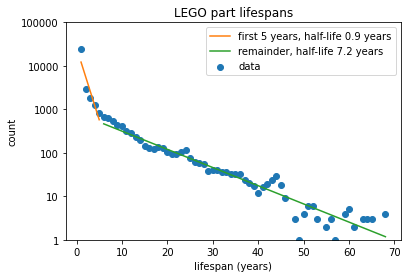

In [12]:
import math
from scipy.optimize import curve_fit

log_lf_counts = np.log10(lf_counts[1])

def lf_log_lin(x, m, c):
  return m * x + c

elbow = 5

fit_params1, _ = curve_fit(lf_log_lin, lf_counts[0][:elbow], log_lf_counts[:elbow])
fit_params2, _ = curve_fit(lf_log_lin, lf_counts[0][elbow:], log_lf_counts[elbow:])

fit_curve1 = lf_log_lin(lf_counts[0][:elbow], fit_params1[0], fit_params1[1])
fit_curve2 = lf_log_lin(lf_counts[0][elbow:], fit_params2[0], fit_params2[1])

plt.scatter(lf_counts[0], log_lf_counts)
plt.plot(lf_counts[0][:elbow], fit_curve1, color='tab:orange')
plt.plot(lf_counts[0][elbow:], fit_curve2, color='tab:green')
plt.ylim((0, 5))
plt.title('LEGO part lifespans')
plt.ylabel('count')
plt.yticks(range(0,6), [int(math.pow(10, y)) for y in range(0,6)])
plt.xlabel('lifespan (years)')
plt.legend([f'first 5 years, half-life {math.log10(2) / -fit_params1[0]:.1f} years',
            f'remainder, half-life {math.log10(2) / -fit_params2[0]:.1f} years', 'data'])
plt.show()

## Churn

In [13]:
def safe_dict(d, k):
  val = 0
  if k in d.keys():
    val = d[k]
  return val 

def year_counts(year_data, year_range):
  ydistn = np.unique(year_data, return_counts=True)
  ydistn_dict = {y[0] : y[1] for y in zip(ydistn[0], ydistn[1])}
  return year_range, [safe_dict(ydistn_dict, y) for y in year_range]

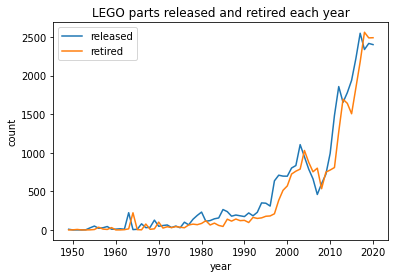

In [14]:
yrange = range(min(min(yrel), min(yret)), max_year + 1)

yrel_counts = year_counts(yrel, yrange)
yret_counts = year_counts(yret, yrange)

plt.plot(yrange, yrel_counts[1])
plt.plot(yrange, yret_counts[1])
plt.title('LEGO parts released and retired each year')
plt.ylabel('count')
plt.xlabel('year')
plt.legend(['released', 'retired'])
plt.show()

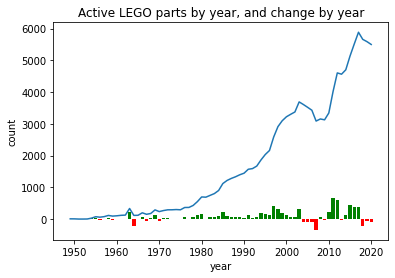

In [15]:
ynet_counts = [rel - ret for rel, ret in zip(yrel_counts[1], yret_counts[1])]
ycumul_counts = np.cumsum(ynet_counts)
plt.plot(yrange, ycumul_counts)
plt.bar(yrange, ynet_counts, color=['green' if nc > 0 else 'red' for nc in ynet_counts])
plt.title('Active LEGO parts by year, and change by year')
plt.ylabel('count')
plt.xlabel('year')
plt.show()

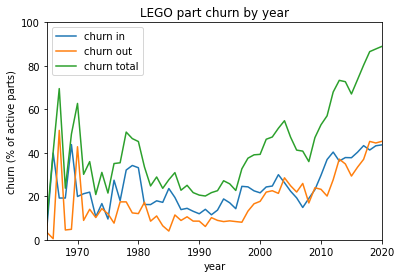

In [16]:
ychurnin = np.array(yrel_counts[1]) / ycumul_counts * 100
ychurnout = np.array(yret_counts[1]) / ycumul_counts * 100

plt.plot(yrange, ychurnin)
plt.plot(yrange, ychurnout)
plt.plot(yrange, ychurnin + ychurnout)
plt.ylim((0, 100))
plt.xlim((1965, max_year))
plt.title('LEGO part churn by year')
plt.legend(['churn in', 'churn out', 'churn total'])
plt.ylabel('churn (% of active parts)')
plt.xlabel('year')
plt.show()

## Lifespan by year released and retired

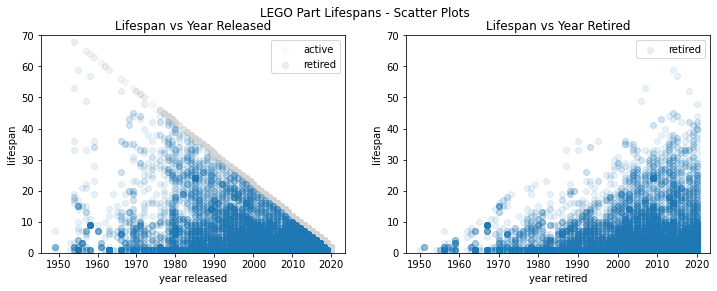

In [17]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

active_ids = [i for i, y in enumerate(yret) if y > max_year]
inactive_ids = [i for i, y in enumerate(yret) if y <= max_year]

ax[0].scatter(np.array(yrel)[active_ids], np.array(lf)[active_ids], alpha=0.1, color='lightgrey')
ax[0].scatter(np.array(yrel)[inactive_ids], np.array(lf)[inactive_ids], alpha=0.1)
ax[0].set_ylim((0, 70))
ax[0].set_title("Lifespan vs Year Released")
ax[0].set_ylabel('lifespan')
ax[0].set_xlabel('year released')
ax[0].legend(['active', 'retired'])

ax[1].scatter(np.array(yret)[inactive_ids], np.array(lf)[inactive_ids], alpha=0.1)
ax[1].set_ylim((0, 70))
ax[1].set_title("Lifespan vs Year Retired")
ax[1].set_ylabel('lifespan')
ax[1].set_xlabel('year retired')
ax[1].legend(['retired'])

fig.suptitle('LEGO Part Lifespans - Scatter Plots')
plt.show()

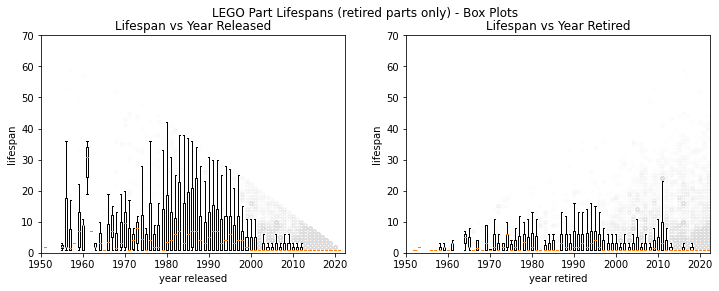

In [18]:
yrel_inactive = np.array(yrel)[inactive_ids]
yret_inactive = np.array(yret)[inactive_ids]
lf_inactive = np.array(lf)[inactive_ids]

lf_by_rel = { y : [] for y in yrange}
lf_by_ret = { y : [] for y in yrange}
for i, y in enumerate(yrel_inactive):
  lf_by_rel[y].append(lf_inactive[i])
for i, y in enumerate(yret_inactive):
  lf_by_ret[y].append(lf_inactive[i])

boxplot_rel_x = np.array([lf_by_rel[y] for y in yrange], dtype=object)
boxplot_ret_x = np.array([lf_by_ret[y] for y in yrange], dtype=object)

fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].boxplot(boxplot_rel_x, flierprops={'markeredgecolor':'#ddd1', 'markersize':3})
ax[0].set_xticks([10 * y for y in range(len(list(yrange[1::10])))])
ax[0].set_xticklabels(yrange[1::10])
ax[0].set_ylim((0, 70))
ax[0].set_title('Lifespan vs Year Released')
ax[0].set_ylabel('lifespan')
ax[0].set_xlabel('year released')

ax[1].boxplot(boxplot_ret_x, flierprops={'markeredgecolor':'#ddd1', 'markersize':3})
ax[1].set_xticks([10 * y for y in range(len(list(yrange[1::10])))])
ax[1].set_xticklabels(yrange[1::10])
ax[1].set_ylim((0, 70))
ax[1].set_title('Lifespan vs Year Retired')
ax[1].set_ylabel('lifespan')
ax[1].set_xlabel('year retired')

fig.suptitle('LEGO Part Lifespans (retired parts only) - Box Plots')
plt.show()

In [19]:
prop_active_to_alltime = ycumul_counts[-1] / len(yrel)
print(f'Currently {prop_active_to_alltime * 100:.0f}% of all parts released are active')

Currently 15% of all parts released are active


# Test Set Ages

In [20]:
test_set_year = int(sets_df[sets_df.index == test_set_num]['year'])
test_response = get_part_list_details(test_part_list)
test_yrel = [p['year_from'] for p in test_response['results']]
test_yret = [p['year_to'] + 1 for p in test_response['results']]
test_lf = [x[1] - x[0] for x in zip(test_yrel, test_yret)]
test_age = [test_set_year - r for r in test_yrel]

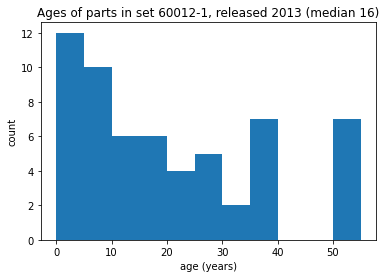

In [21]:
plt.hist(test_age, bins=11)
plt.title(f'Ages of parts in set {test_set_num}, released {test_set_year} (median {np.median(test_age):.0f})')
plt.ylabel('count')
plt.xlabel('age (years)')
plt.show()

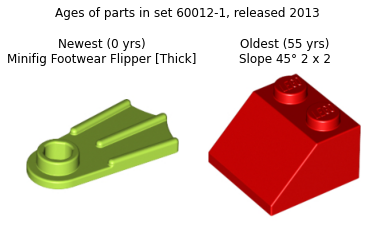

In [22]:
from PIL import Image

max_id = np.argmax(test_age)
oldest_part = test_response['results'][max_id]
min_id = np.argmin(test_age)
youngest_part = test_response['results'][min_id]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(Image.open(requests.get(youngest_part['part_img_url'], stream=True).raw))
ax[0].set_title(f'Newest ({min(test_age)} yrs)\n{youngest_part["name"]}')
ax[0].axis('off')

ax[1].imshow(Image.open(requests.get(oldest_part['part_img_url'], stream=True).raw))
ax[1].set_title(f'Oldest ({max(test_age)} yrs)\n{oldest_part["name"]}')
ax[1].axis('off')
fig.suptitle(f'Ages of parts in set {test_set_num}, released {test_set_year}')
plt.show()